In [1]:
%matplotlib inline
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import collections
import numpy as np

from main import plot_segments, plot_lines
from cluster import cluster_segments
from optimize import find_vanishing_points
from itertools import permutations, combinations
from linesegmentintersections import bentley_ottman

In [40]:
%matplotlib qt
IM_PATH = "pb_court_1.jpg"

im = cv.cvtColor(cv.imread(IM_PATH), cv.COLOR_BGR2RGB)
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
plt.imshow(im)
plt.xlim(-100, 1000)

plt.figure()
plt.imshow(im_gray, cmap="gray")

# plt.figure()
# im_gaus = cv.GaussianBlur(im, (31, 31), 0)
# im_blur = cv.medianBlur(im_gray, 51)
# im_mask = np.abs(im_gray - im_blur) < 200
# plt.imshow(im_mask, cmap="gray")
# plt.imshow(im_gaus)

1418
2950


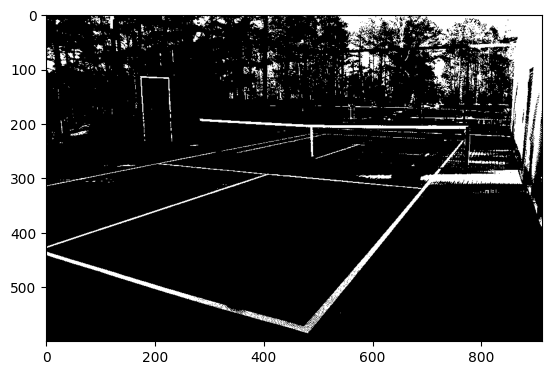

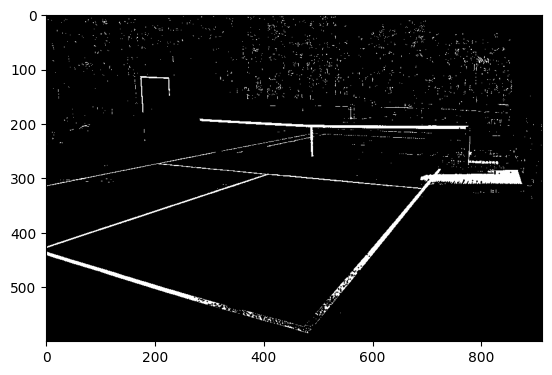

In [3]:
retval, im_thresh = cv.threshold(im_gray, 200, 255, cv.THRESH_BINARY)
plt.imshow(im_thresh, cmap="gray")
plt.figure()

area_threshold = 100

def is_bad(con, im):
    convex_area = cv.contourArea(cv.convexHull(con))
    area = cv.contourArea(con)

    if area > 1 and area / convex_area > 0.25:
        con_mask = cv.drawContours(np.zeros_like(im), [con], -1, 1, -1)
        white_ratio = np.sum(np.multiply(im, con_mask)) / np.sum(con_mask) / 255
        if white_ratio > 0.25:
            return True
    
    return False
    # return area > 1000 and area / convex_area > 0.5

contours, _ = cv.findContours(im_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
bad_contours = [con for con in contours if is_bad(con, im_thresh)]
im_thresh_trim = cv.drawContours(im_thresh, bad_contours, -1, 0, -1)
plt.imshow(im_thresh_trim, cmap="gray")
print(len(bad_contours))
print(len(contours))

(48, 4)


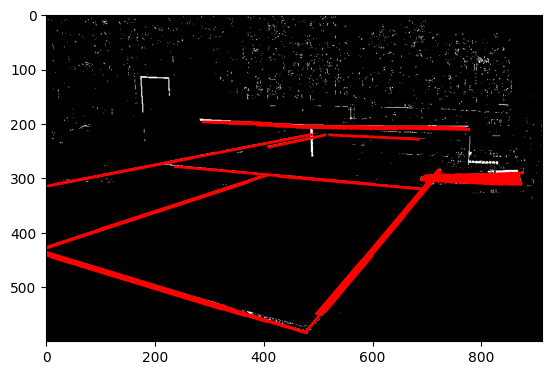

In [4]:
hough_lines = cv.HoughLinesP(
    image=im_thresh,
    rho=1,
    theta=np.pi / 180,
    threshold=75,
    minLineLength=50,
    maxLineGap=15,
)[:, 0, :]


_, ax1 = plt.subplots()
ax1.imshow(im_thresh, cmap="gray")
plot_segments(ax1, hough_lines, colors=["red"], linewidths=[2])
print(hough_lines.shape)

(11, 4)


<Figure size 640x480 with 0 Axes>

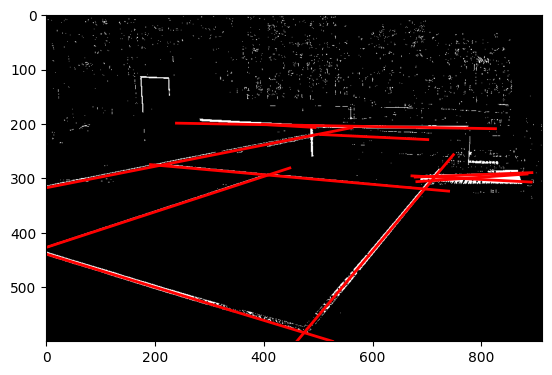

In [35]:
avg_lines = cluster_segments(hough_lines)["average_lines"]

# extend the lines by 10% per side to guarantee intersections
x1 = avg_lines[:, 0]
y1 = avg_lines[:, 1]
x2 = avg_lines[:, 2]
y2 = avg_lines[:, 3]
v12 = (avg_lines[:, 2:4] - avg_lines[:, 0:2])
extended_avg_lines = avg_lines.copy()
extended_avg_lines[:, 0:2] -= v12 * 0.1
extended_avg_lines[:, 2:4] += v12 * 0.1

plt.figure()
_, ax2 = plt.subplots()
ax2.imshow(im_thresh, cmap="gray")
plot_segments(ax2, extended_avg_lines, colors=["red"], linewidths=[2])
print(avg_lines.shape)

In [6]:
def get_intersection(l1: np.ndarray, l2: np.ndarray) -> np.ndarray | None:
    segments = np.asarray([[l1[:2], l1[2:]], [l2[:2], l2[2:]]]).tolist()
    intersections = bentley_ottman(segments)
    if len(intersections) > 0:
        return intersections[0].x, intersections[0].y
    else:
        return None

intersections = {}
for i, line_i in enumerate(extended_avg_lines):
    for j, line_j in enumerate(extended_avg_lines):
        if i < j:
            continue
        pt = get_intersection(line_i, line_j)
        if pt is not None:
            intersections[pt] = (i, j)

# plt.figure()
# _, ax1 = plt.subplots()
# ax1.imshow(im_thresh, cmap="gray")
# plot_segments(ax1, extended_avg_lines, colors=["red"], linewidths=[1])
# for pt in intersections:
#     ax1.scatter(x=pt[0], y=pt[1])
#     ax1.text(x=pt[0], y=pt[1], s=str(intersections[pt]), fontweight="bold", color="yellow")
# from pprint import pprint; pprint(intersections)

graph = {pt: [] for pt in intersections}
for pt1, pt2 in combinations(intersections, r=2):
    if set(intersections[pt1]).intersection(set(intersections[pt2])):
        graph[pt1].append(pt2)
        graph[pt2].append(pt1)


# for pt, children in graph.items():
#     children = np.array(children).reshape((-1, 2))
#     plt.figure()
#     _, ax2 = plt.subplots()
#     ax2.imshow(im_thresh, cmap="gray")
#     plot_segments(ax2, extended_avg_lines, colors=["red"], linewidths=[1])

#     ax2.scatter(x=pt[0], y=pt[1])
#     ax2.text(x=pt[0], y=pt[1], s=str(intersections[pt]), fontweight="bold", color="yellow")
#     ax2.scatter(x=children[:, 0], y=children[:, 1])

# A corner is comprised of 3 nodes q r s where q shares an edge with r shares an edge with s
# but q and s do not share an edge.
corners = []
for q in graph:
    for r in graph[q]:
        for s in graph[r]:
            if (
                q != r and
                r != s and
                s != q and
                s not in graph[q]
            ):
                corners.append([q, r, s])
corners = np.array(corners)

# for corner in corners:
#     corner = np.array(corner)
#     plt.figure()
#     _, ax2 = plt.subplots()
#     ax2.imshow(im_thresh, cmap="gray")
#     plot_segments(ax2, extended_avg_lines, colors=["red"], linewidths=[1])
#     ax2.scatter(x=corner[:, 0], y=corner[:, 1])

print(len(corners))

58


In [211]:
from court_graph import COURT_CORNERS, DENSE_COURT_POINTS, COURT_COORDS
from focal_length import get_focal_length

#https://github.com/aliyasineser/GraduationProjectII/blob/master/RelativePositionTest.py
def inversePerspective(rvec, tvec):
    R, _ = cv.Rodrigues(rvec)
    R = np.matrix(R).T
    invTvec = np.dot(-R, np.matrix(tvec))
    invRvec, _ = cv.Rodrigues(R)
    return invRvec, invTvec


im_height, im_width, _ = im.shape

# my_im_corners = np.array([[[474, 583], [695, 320], [209, 276]]], dtype=float)
# my_court_corners = np.array([[[20, 0, 0], [20, 15, 0], [0, 15, 0]]]) * 0.3048

# my_im_corners = corners
# my_court_corners = COURT_CORNERS

im_target = cv.dilate(im_thresh, np.ones((3, 3)))

fs = []
rounds = []
for im_corner in corners:
    p1, p2, p3 = im_corner
    for court_corner in COURT_CORNERS:
        X1, X2, X3 = court_corner
        f12 = get_focal_length(p1, p2, X1, X2, im_width, im_height)
        f23 = get_focal_length(p2, p3, X2, X3, im_width, im_height)

        # TODO: UNDO THIS. I THINK get_focal_length is wrong. Probably my math ;(
        f12 = 709
        f23 = 709

        f_avg = np.average([f12, f23])

        f_err = abs(f12 - f23) / f_avg

        if f_err < 0.3:
            fs.append(f_avg)

            K = np.array([
                [f_avg, 0, im_width / 2],
                [0, f_avg, im_height / 2],
                [0, 0, 1],
            ])

            retval, rvecs, tvecs = cv.solveP3P(objectPoints=court_corner, imagePoints=im_corner, cameraMatrix=K, distCoeffs=np.zeros((4, 1)), flags=cv.SOLVEPNP_AP3P)
            
            for rvec, tvec in zip(rvecs, tvecs):
                pts_proj, _ = cv.projectPoints(
                    objectPoints=DENSE_COURT_POINTS,
                    rvec=rvec,
                    tvec=tvec,
                    cameraMatrix=K,
                    distCoeffs=np.zeros((4, 1)),
                )
                pts_proj = np.array(pts_proj, dtype=int).squeeze()
                bool_mask = np.logical_and(
                    np.logical_and(
                        pts_proj[:, 0] < im_width,
                        pts_proj[:, 1] < im_height),
                    np.all(pts_proj > 0, axis=1),
                )
                pts_proj_safe = pts_proj[bool_mask]
                pts_proj_on_im = im_target.T[pts_proj_safe[:, 0], pts_proj_safe[:, 1]]
                score = np.sum(pts_proj_on_im > 0) - len(pts_proj) - np.sum(pts_proj_on_im == 0)
                rounds.append((score, K, rvec, tvec, im_corner, court_corner))

C:\Users\echapman\AppData\Local\Temp\ipykernel_33480\3415811285.py:59: RuntimeWarning: invalid value encountered in cast
  pts_proj = np.array(pts_proj, dtype=int).squeeze()


-1104
tvec [[ 4.31394701]
 [ 0.38911363]
 [12.59017209]]
rvec [[ 0.53186083]
 [-2.15004461]
 [ 1.75070013]]


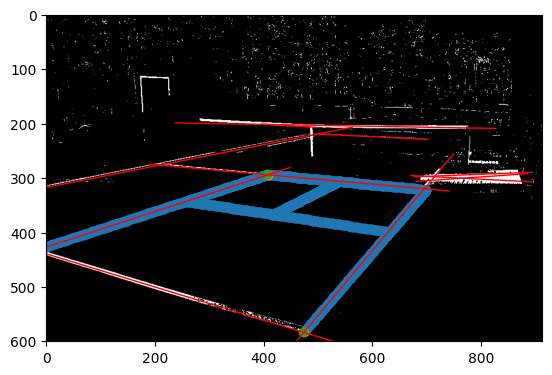

In [214]:
from IPython.display import clear_output

rounds = sorted(rounds, key=lambda tup: tup[0], reverse=True)
print(len(rounds))

for i in range(len(rounds)):
    score, K, rvec, tvec, im_corner, court_corner = rounds[i]

    p1, p2, p3 = im_corner
    if np.linalg.norm(p1 - p2) < 100 or np.linalg.norm(p2 - p3) < 100:
        continue
    
    # wanted_court_corner = np.array([COURT_COORDS["d"], COURT_COORDS["f"], COURT_COORDS["c"]])
    # if not np.allclose(court_corner, wanted_court_corner):
    #     continue

    if input(str(i)):
        break
    clear_output()

    pts_proj = np.array(
        cv.projectPoints(
            objectPoints=DENSE_COURT_POINTS,
            rvec=rvec,
            tvec=tvec,
            cameraMatrix=K,
            distCoeffs=np.zeros((4, 1)),
        )[0],
        dtype=int
    ).squeeze()

    corner_proj = np.array(
        cv.projectPoints(
            objectPoints=court_corner,
            rvec=rvec,
            tvec=tvec,
            cameraMatrix=K,
            distCoeffs=np.zeros((4, 1)),
        )[0],
        dtype=int
    ).squeeze()

    print(score)
    print('tvec', tvec)
    print('rvec', rvec)
    _, ax = plt.subplots()
    ax.imshow(im_thresh, cmap="gray")
    plot_segments(ax, extended_avg_lines, colors=["red"], linewidths=[1])
    plt.scatter(x=pts_proj[:, 0], y=pts_proj[:, 1])
    plt.scatter(x=im_corner[:, 0], y=im_corner[:, 1])
    plt.scatter(x=corner_proj[:, 0], y=corner_proj[:, 1])
    ax.set_xlim((0, im.shape[1]))
    ax.set_ylim((im.shape[0], 0))
    plt.show()

(1, 5, 2)
(1, 5, 3)
[[727.27738659   0.         455.5       ]
 [  0.         727.27738659 299.5       ]
 [  0.           0.           1.        ]]
[[0. 0. 0. 0. 0.]]
(array([[ 1.74340779],
       [ 0.42996179],
       [-0.34798124]]),)
(array([[-5.32239545],
       [ 0.4787943 ],
       [ 5.55458855]]),)


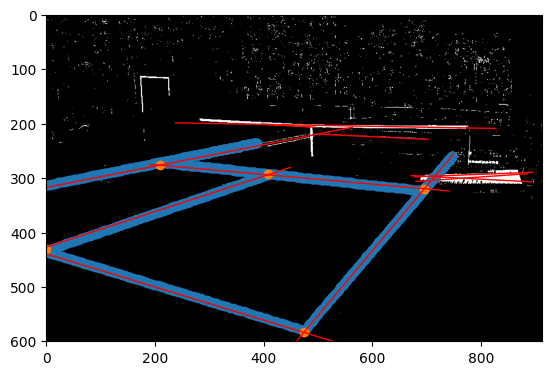

In [226]:


ps = np.array([[[474, 583], [695, 320], [209, 276], [408, 293], [0, 430]]], dtype=np.float32)
Xs = np.array([[[20, 0, 0], [20, 15, 0], [0, 15, 0], [10, 15, 0], [10, 0, 0]]], dtype=np.float32) * 0.3048

print(ps.shape)
print(Xs.shape)
f = 709
K = np.array([
    [f, 0, im_width / 2],
    [0, f, im_height / 2],
    [0, 0, 1],
])
ret, K, dist, rvec, tvec = cv.calibrateCamera(
    objectPoints=Xs,
    imagePoints=ps,
    imageSize=im.shape[:2][::-1],
    cameraMatrix=None,
    distCoeffs=None,
    flags=cv.CALIB_FIX_PRINCIPAL_POINT + cv.CALIB_FIX_ASPECT_RATIO +
        cv.CALIB_FIX_S1_S2_S3_S4 + cv.CALIB_FIX_K1 + cv.CALIB_FIX_K2 + cv.CALIB_FIX_K3 + cv.CALIB_FIX_K4 + cv.CALIB_FIX_K5 + cv.CALIB_FIX_K6 +
        cv.CALIB_FIX_TAUX_TAUY + cv.CALIB_FIX_TANGENT_DIST,
)

print(K)
print(dist)
print(rvec)
print(tvec)

rvec = rvec[0]
tvec = tvec[0]

pts_proj = np.array(
    cv.projectPoints(
        objectPoints=DENSE_COURT_POINTS,
        rvec=rvec,
        tvec=tvec,
        cameraMatrix=K,
        distCoeffs=np.zeros((4, 1)),
    )[0],
    dtype=int
).squeeze()

_, ax = plt.subplots()
ax.imshow(im_thresh, cmap="gray")
plot_segments(ax, extended_avg_lines, colors=["red"], linewidths=[1])
plt.scatter(x=pts_proj[:, 0], y=pts_proj[:, 1])
plt.scatter(x=ps[:, :, 0], y=ps[:, :, 1])
ax.set_xlim((0, im.shape[1]))
ax.set_ylim((im.shape[0], 0))
plt.show()

7912
[0 0 0]
0
255


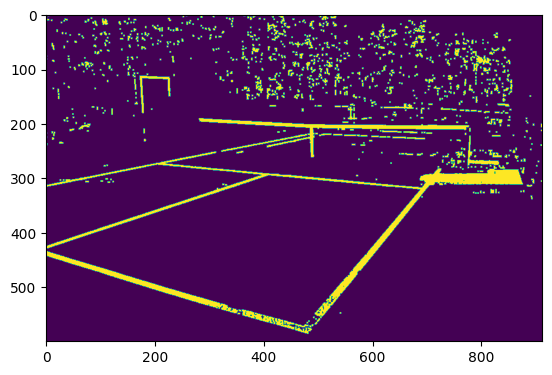

In [209]:
rounds = sorted(rounds, key=lambda tup: tup[0])
print(len(rounds))
fs = [round[1][1, 1] for round in rounds]
plt.hist(fs)

pts = np.array([[10, 10], [25, 20], [4, 2]])

print(im_thresh[pts[:, 0], pts[:, 1]])

print(np.min(im_thresh))
print(np.max(im_thresh))
 
kernel = np.ones((3, 3))
plt.imshow(cv.dilate(im_thresh, kernel))
# plt.imshow(cv.dilate(cv.erode(im_thresh, kernel), kernel, 10))
# plt.imshow(cv.morphologyEx(im_thresh, cv.MORPH_OPEN, kernel))
# print(im_thresh.shape)

# print(im_thresh[zip(*pts)])
